In [1]:
import glob
from tqdm import tqdm
import pickle
import os
import numpy as np
import jax
import bayes3d as b
import subprocess
paths = "/home/arijitdasgupta/bayes3d/scripts/experiments/intphys/mcs/pickled_data/*pkl"
files = sorted(glob.glob(paths))
import sys
from genjax._src.core.pytree.utilities import *
from genjax.generative_functions.distributions import ExactDensity
import jax.tree_util as jtu
from genjax._src.core.transforms.incremental import NoChange, UnknownChange, Diff
import genjax
from tensorflow_probability.substrates import jax as tfp
sys.path.append("../")
from viz import *
from utils import *
from mcs_utils import *
console = genjax.pretty()
gt_bin = np.array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [223]:
testing_files = files[:]
# testing_files.remove(testing_files[5])
for file in tqdm(testing_files):
    scene_name = file.split("/")[-1][:-4]
    print(scene_name)
    # with open(f"/home/arijitdasgupta/bayes3d/scripts/experiments/intphys/mcs/results_4/results_{scene_name}.pkl", 'rb') as file:
    #     results = pickle.load(file)
    # print(scene_name)
    # display(display_video(results["viz"]))

100%|██████████| 62/62 [00:00<00:00, 131204.26it/s]

passive_physics_validation_gravity_support_0001_01
passive_physics_validation_gravity_support_0001_02
passive_physics_validation_gravity_support_0001_03
passive_physics_validation_gravity_support_0001_04
passive_physics_validation_gravity_support_0001_05
passive_physics_validation_gravity_support_0001_06
passive_physics_validation_gravity_support_0001_07
passive_physics_validation_gravity_support_0001_08
passive_physics_validation_gravity_support_0001_09
passive_physics_validation_gravity_support_0001_10
passive_physics_validation_gravity_support_0001_11
passive_physics_validation_gravity_support_0001_12
passive_physics_validation_gravity_support_0001_13
passive_physics_validation_gravity_support_0001_14
passive_physics_validation_gravity_support_0001_15
passive_physics_validation_gravity_support_0001_16
passive_physics_validation_gravity_support_0001_17
passive_physics_validation_gravity_support_0001_18
passive_physics_validation_gravity_support_0001_19
passive_physics_validation_grav

In [ ]:
def load_path(scene_name):
    with open(f"/home/arijitdasgupta/bayes3d/scripts/experiments/intphys/mcs/results_4/results_{scene_name}.pkl", 'rb') as file:
        return pickle.load(file)

In [168]:
with open(f"/home/arijitdasgupta/bayes3d/scripts/experiments/intphys/mcs/results_5/results_passive_physics_validation_shape_constancy_0001_05.pkl", 'rb') as file:
    results = pickle.load(file)
display_video(results["viz"])

<IPython.core.display.HTML object>

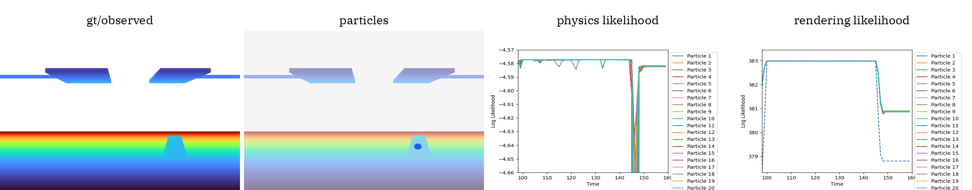

In [178]:
results['viz'][-1]

In [222]:
import csv

# Replace 'yourfile.csv' with the path to your CSV file
# Replace new_data list with the values you want to add
new_data = ['value1', 'value2', 'value3']

with open('yourfile.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(new_data)

In [202]:
def determine_plausibility(results, offset = 3, rend_fraction_thresh = 0.75):
    # check to see if object is falling from top
    # height, width = results['rendered'].shape
    results['variance'] = 0.1
    results['intrinsics'] = b.Intrinsics(
        height=80,
        width=120,
        fx=102.85982935966132,
        fy=102.85982935966129,
        cx=60.0,
        cy=40.0,
        near=0.009999999776482582,
        far=150.0
    )
    T = results['resampled_indices'].shape[0] - offset
    tsteps_before_start = results['inferred_poses'].shape[0] - T

    height, width = results['intrinsics'].height, results['intrinsics'].width
    starting_indices = results['all_obj_indices'][tsteps_before_start - offset]
    if starting_indices is not []:
        mean_i, mean_j = np.median(starting_indices[:,0]), np.median(starting_indices[:,1])
        from_top = (mean_i < height/2) and (mean_j > mean_i) and (mean_j < width -mean_i)
    else:
        from_top = False

    # first get base indices to reflect resampled particles
    n_particles = results['resampled_indices'].shape[1]
    resample_bools = np.all(results['resampled_indices'] == np.arange(n_particles), axis = 1)
    base_indices = np.arange(n_particles)
    for i in range(results['resampled_indices'].shape[0]):
        base_indices = base_indices[results['resampled_indices'][i]]
    # then get the rendering scores based on resampled_indices
    rend = np.array(results["rend_ll"][offset:,base_indices])
    # get the worst rendered scores (object-less)
    WR = results["worst_rend"][offset:]
    # flatten rend to get the best vector across time
    rend = np.max(rend, axis = 1)

    max_rend_possible = height * width * jax.scipy.stats.norm.pdf(
        0.,
        loc=0.0, 
        scale=results["variance"]
    ) * 0.01

    t_violation = None
    plausibility_list = [True for _ in range(tsteps_before_start)]
    plausible = True
    for t in range(T):
        if WR[t] > rend[t]:
            plausible = False
            if t_violation is None:
                t_violation = tsteps_before_start + t
        if WR[t] < max_rend_possible and WR[t] == rend[t]:
            plausible = False
            if t_violation is None:
                t_violation = tsteps_before_start + t
        if from_top and rend[t] > WR[t] and WR[t] >= WR[t-1] and t > T/2:
            WR_gap = max_rend_possible - WR[t]
            rend_gap = max_rend_possible - rend[t]
            rend_likelihood_fraction = (WR_gap - rend_gap)/WR_gap
            if rend_likelihood_fraction < rend_fraction_thresh:
                plausible = False
                if t_violation is None:
                    t_violation = tsteps_before_start + t

        plausibility_list.append(plausible)
    return plausible, t_violation, plausibility_list, from_top



In [196]:
determine_plausibility(results)[:2]

98 62


(False, 149)

In [4]:
with open("../final_result_xxx.pkl", "rb") as file:
    rr = pickle.load(file)

rr


{
    'rating': 1,
    'score': 1.0,
    'report': {
        1: {'rating': 1, 'score': 1.0},
        2: {'rating': 1, 'score': 1.0},
        3: {'rating': 1, 'score': 1.0},
        4: {'rating': 1, 'score': 1.0},
        5: {'rating': 1, 'score': 1.0},
        6: {'rating': 1, 'score': 1.0},
        7: {'rating': 1, 'score': 1.0},
        8: {'rating': 1, 'score': 1.0},
        9: {'rating': 1, 'score': 1.0},
        10: {'rating': 1, 'score': 1.0},
        11: {'rating': 1, 'score': 1.0},
        12: {'rating': 1, 'score': 1.0},
        13: {'rating': 1, 'score': 1.0},
        14: {'rating': 1, 'score': 1.0},
        15: {'rating': 1, 'score': 1.0},
        16: {'rating': 1, 'score': 1.0},
        17: {'rating': 1, 'score': 1.0},
        18: {'rating': 1, 'score': 1.0},
        19: {'rating': 1, 'score': 1.0},
        20: {'rating': 1, 'score': 1.0},
        21: {'rating': 1, 'score': 1.0},
        22: {'rating': 1, 'score': 1.0},
        23: {'rating': 1, 'score': 1.0},
        24: 

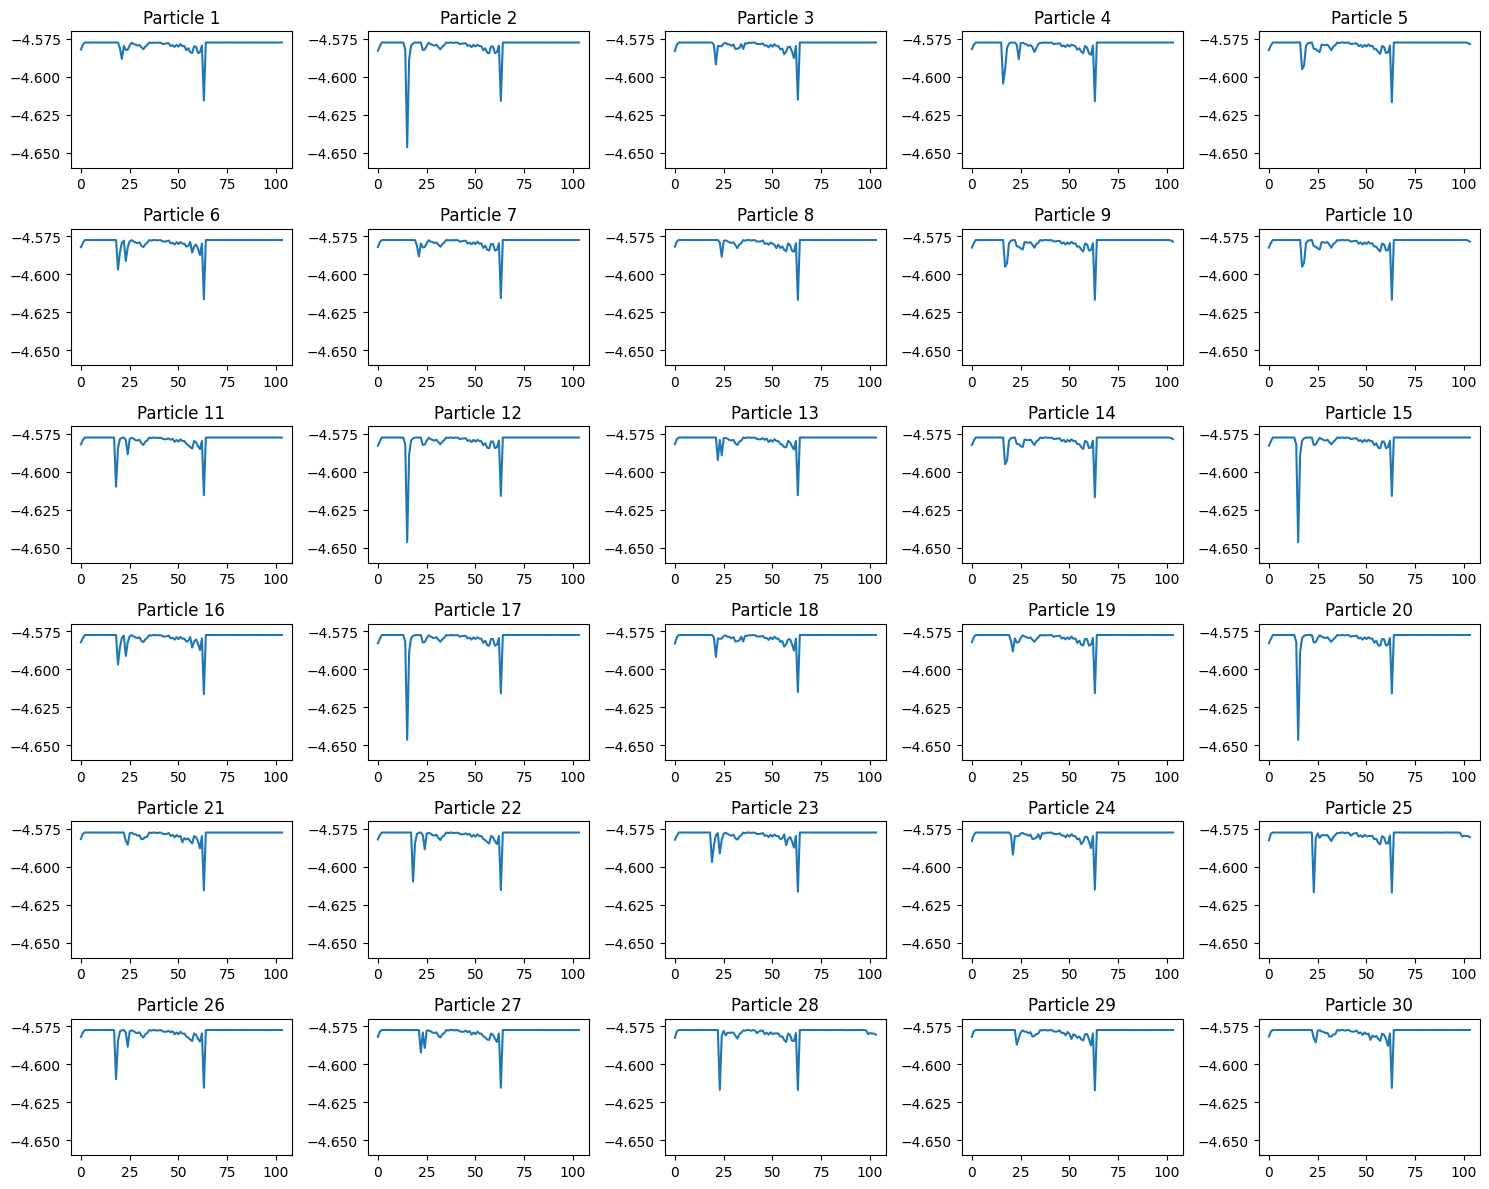

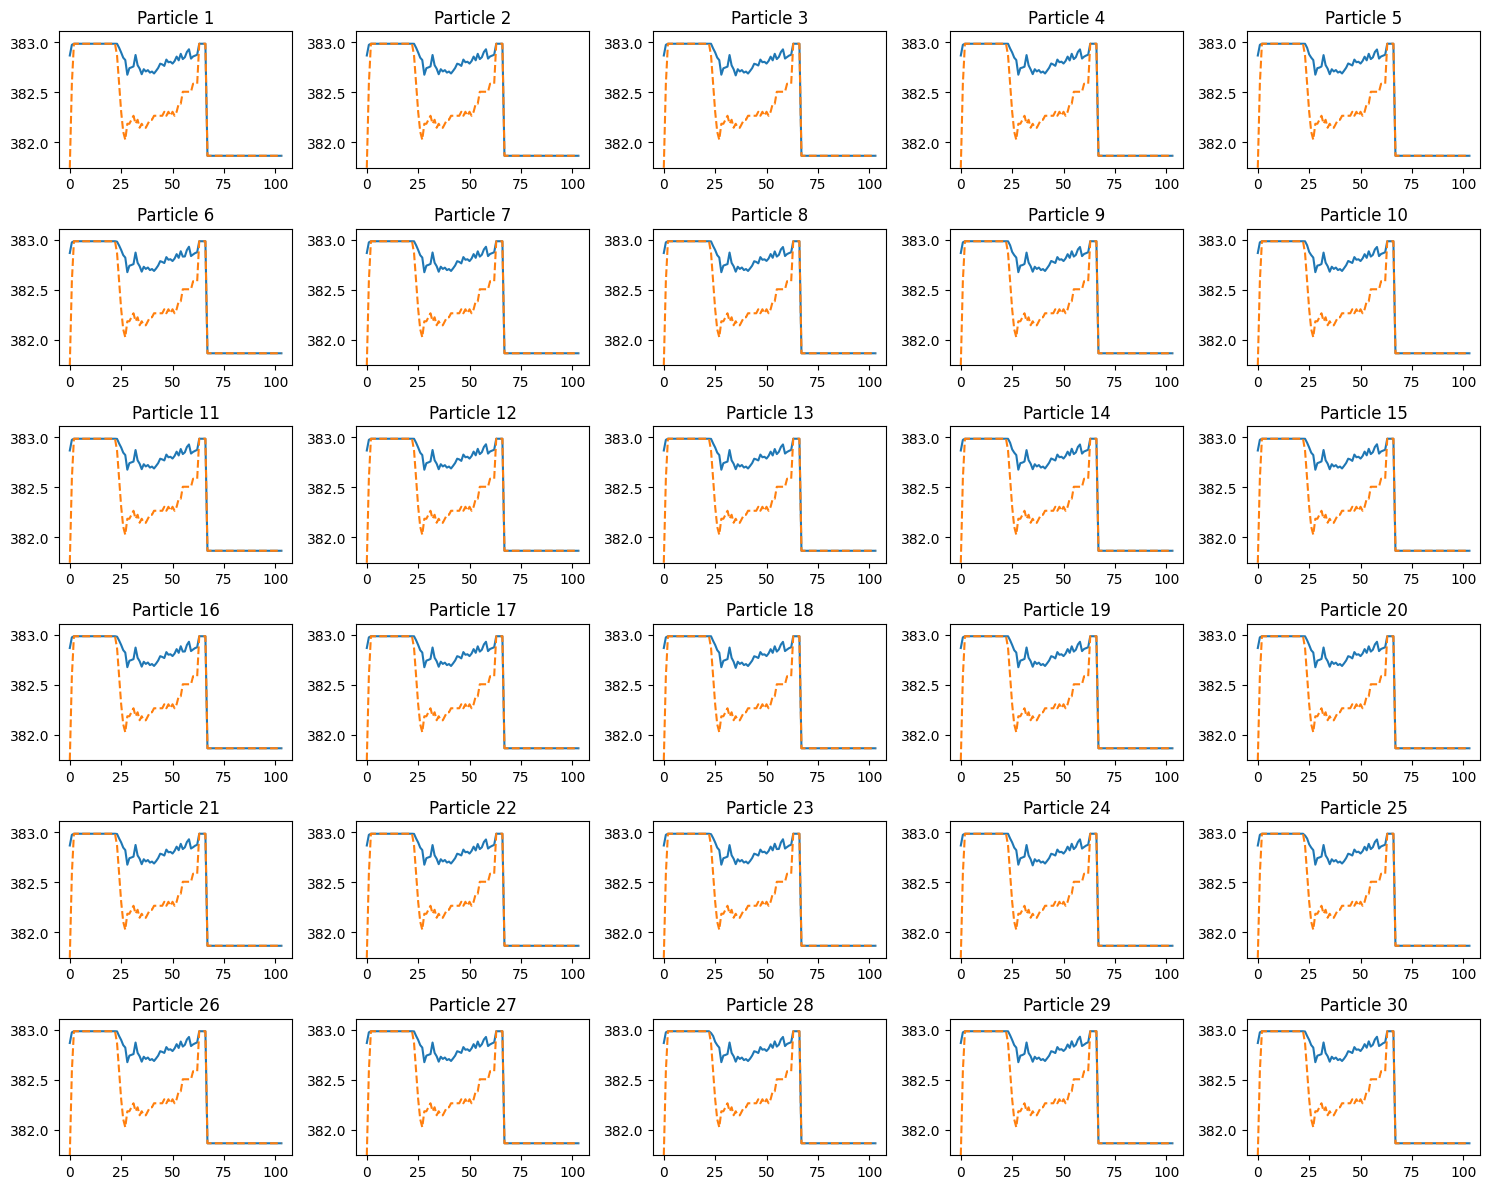

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: this is code used to check if resampling happened
n_particles = results['resampled_indices'].shape[1]
jnp.all(results['resampled_indices'] == np.arange(n_particles), axis = 1)

base_indices = np.arange(n_particles)
for i in range(results['resampled_indices'].shape[0]):
    base_indices = base_indices[results['resampled_indices'][i]]

max_rend_ll = 9600*jax.scipy.stats.norm.pdf(
        0.,
        loc=0.0, 
        scale=0.1
    ) * 0.01
offst = 3
# scene = implausible_perm_results[3]
scene = results# implausible_perm_results[3]

worst_rend = scene["worst_rend"]

data = scene["phy_ll"][0][offst:]

fig, axes = plt.subplots(6, 5, figsize=(15, 12))  # Adjust figsize as needed

# Set global min and max for y-axis
ymin, ymax = np.min(data), np.max(data)

for i in range(30):
    ax = axes[i//5, i%5]
    ax.plot(data[:, base_indices[i]])
    ax.set_ylim([-4.66, -4.57])  # Set the same y-axis limits for all plots
    ax.set_title(f"Particle {i+1}")
    # ax.set_yscale("log")

plt.tight_layout()
plt.show()


data = scene["rend_ll"][offst:]

fig, axes = plt.subplots(6, 5, figsize=(15, 12))  # Adjust figsize as needed

# Set global min and max for y-axis
ymin, ymax = np.min(data), np.max(data)

for i in range(30):
    ax = axes[i//5, i%5]
    ax.plot(data[:, base_indices[i]])
    ax.plot(worst_rend[offst:], linestyle="--")
    ax.set_ylim([worst_rend[offst:].min(),max_rend_ll + 0.1*(max_rend_ll - worst_rend[offst:].min())])
    ax.set_title(f"Particle {i+1}")
    # ax.set_yscale("log")



plt.tight_layout()
plt.show()

In [ ]:
# TODO: this is code used to check if resampling happened
n_particles = results['resampled_indices'].shape[1]
resampled_bool = jnp.all(results['resampled_indices'] == np.arange(n_particles), axis = 1)

base_indices = np.arange(n_particles)
for i in range(results['resampled_indices'].shape[0]):
    base_indices = base_indices[results['resampled_indices'][i]]

In [ ]:
resampled_bool

In [213]:
def load_path(scene_name):
    with open(f"/home/arijitdasgupta/bayes3d/scripts/experiments/intphys/mcs/results_5/results_{scene_name}.pkl", 'rb') as file:
        return pickle.load(file)

plausible_scenes = [files[i].split("/")[-1][:-4] for i in range(62) if gt_bin[i] == 1]
implausible_scenes = [files[i].split("/")[-1][:-4] for i in range(62) if gt_bin[i] == 0]

plausible_scenes_perm = [x for x in plausible_scenes if "permanence" in x]
implausible_scenes_perm = [x for x in implausible_scenes if "permanence" in x]

plausible_perm_results = [determine_plausibility(load_path(x))[0] for x in plausible_scenes_perm]
implausible_perm_results = [determine_plausibility(load_path(x))[0] for x in implausible_scenes_perm]

plausible_scenes_shape = [x for x in plausible_scenes if "shape" in x]
implausible_scenes_shape = [x for x in implausible_scenes if "shape" in x]

plausible_shape_results = [determine_plausibility(load_path(x),3,0.75)[0] for x in plausible_scenes_shape]
implausible_shape_results = [determine_plausibility(load_path(x),3,0.75)[0] for x in implausible_scenes_shape]

plausible_scenes_cont = [x for x in plausible_scenes if "continuity" in x]
implausible_scenes_cont = [x for x in implausible_scenes if "continuity" in x]

plausible_cont_results = [determine_plausibility(load_path(x))[0] for x in plausible_scenes_cont]
implausible_cont_results = [determine_plausibility(load_path(x))[0] for x in implausible_scenes_cont]

/opt/conda/envs/bayes3d/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/bayes3d/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [214]:
display(implausible_cont_results)
display(implausible_perm_results)
display(implausible_shape_results)
display(plausible_cont_results)
display(plausible_perm_results)
display(plausible_shape_results)

[False, False, False, False, False, False]

[False, False, False, False, False, False, False, False]

[False, False, False]

[True, True, True, True, True, True]

[True, True, True, True, True, True, True]

[True, True]

In [150]:
for x in plausible_scenes_perm:
    print(x, determine_plausibility(load_path(x))[3])
for x in implausible_scenes_perm:
    print(x, determine_plausibility(load_path(x))[3])

for x in plausible_scenes_cont:
    print(x, determine_plausibility(load_path(x))[3])
for x in implausible_scenes_cont:
    print(x, determine_plausibility(load_path(x))[3])

for x in plausible_scenes_shape:
    print(x, determine_plausibility(load_path(x))[3])
for x in implausible_scenes_shape:
    print(x, determine_plausibility(load_path(x))[3])

passive_physics_validation_object_permanence_0001_15 True
passive_physics_validation_object_permanence_0001_19 False
passive_physics_validation_object_permanence_0001_20 False
passive_physics_validation_object_permanence_0001_23 False
passive_physics_validation_object_permanence_0001_24 False
passive_physics_validation_object_permanence_0001_27 False
passive_physics_validation_object_permanence_0001_28 False
passive_physics_validation_object_permanence_0001_01 False
passive_physics_validation_object_permanence_0001_02 False
passive_physics_validation_object_permanence_0001_03 True
passive_physics_validation_object_permanence_0001_07 False
passive_physics_validation_object_permanence_0001_08 False


/opt/conda/envs/bayes3d/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/bayes3d/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


passive_physics_validation_object_permanence_0001_09 False
passive_physics_validation_object_permanence_0001_13 False
passive_physics_validation_object_permanence_0001_14 False
passive_physics_validation_spatio_temporal_continuity_0001_01 False
passive_physics_validation_spatio_temporal_continuity_0001_02 False
passive_physics_validation_spatio_temporal_continuity_0001_03 False
passive_physics_validation_spatio_temporal_continuity_0001_13 False
passive_physics_validation_spatio_temporal_continuity_0001_14 False
passive_physics_validation_spatio_temporal_continuity_0001_15 False
passive_physics_validation_spatio_temporal_continuity_0001_07 False
passive_physics_validation_spatio_temporal_continuity_0001_08 False
passive_physics_validation_spatio_temporal_continuity_0001_09 False
passive_physics_validation_spatio_temporal_continuity_0001_19 False
passive_physics_validation_spatio_temporal_continuity_0001_20 False
passive_physics_validation_spatio_temporal_continuity_0001_21 False
passive

In [ ]:
plausible_rend_markers = [np.min(np.max(x["rend_ll"][3:,:],axis=1)) for x in plausible_perm_results]
implausible_rend_markers = [np.min(np.max(x["rend_ll"][3:,:],axis=1)) for x in implausible_perm_results]

In [ ]:
plausible_rend_markers

In [ ]:
implausible_rend_markers

In [ ]:
plausible_phy_markers = [np.min(np.median(x["phy_ll"][0][3:,:],axis=1)) for x in plausible_perm_results]
implausible_phy_markers = [np.min(np.median(x["phy_ll"][0][3:,:],axis=1)) for x in implausible_perm_results]

In [ ]:
plausible_phy_markers, plausible_scenes_perm

In [ ]:
implausible_phy_markers, implausible_scenes_perm

In [ ]:
# Create a scatter plot for the first cluster (in blue)
plt.scatter(plausible_phy_markers, plausible_rend_markers, c='blue', label='Plausible')

# Create a scatter plot for the second cluster (in red)
plt.scatter(implausible_phy_markers, implausible_rend_markers, c='red', label='Implausible')

# Add labels and a title
plt.xlabel('Physics LL')
plt.ylabel('Rend LL')
plt.title('Cluster Plot')

# Add a legend to distinguish between clusters
plt.legend()

# Display the plot
plt.show()

In [ ]:
implausible_scenes_perm

In [ ]:
params = (jnp.array([1e-0,1e-0,5e-1]), 5e-1)
# params = (1e+20, 0)
display(b.gaussian_vmf_pose.logpdf(jnp.eye(4), jnp.eye(4).at[:3,3].set([0,0,0]), *params))
display(b.gaussian_vmf_pose.logpdf(jnp.eye(4), jnp.eye(4).at[:3,3].set([0.005,0.0,0.0]), *params))
display(b.gaussian_vmf_pose.logpdf(jnp.eye(4), jnp.eye(4).at[:3,3].set([0.0,1,0.0]), *params))
display(b.gaussian_vmf_pose.logpdf(jnp.eye(4), jnp.eye(4).at[:3,3].set([0.0,0.0,1]), *params))
# 0.02 ll diff for movement of away

In [ ]:
display(b.gaussian_vmf_pose.logpdf(jnp.eye(4), jnp.eye(4).at[:3,3].set([1,0,0]), *(5e-0,5e-1)))

In [ ]:
params = [1,1,1]
display(genjax.tfp_mv_normal_diag.logpdf([0,0,0],[0,0,0],params))
display(genjax.tfp_mv_normal_diag.logpdf([0.1,0.1,0.0],[0,0,0],params))
display(genjax.tfp_mv_normal_diag.logpdf([0.0,0.1,0.1],[0,0,0],params))


In [ ]:
qs = jnp.linspace(0.05,0.95,30)
tfp.distributions.Normal(0.02,0.05).quantile(qs)

In [ ]:
display(9600*jax.scipy.stats.norm.pdf(
        np.array([0.]),
        loc=0.0, 
        scale=0.1
    ) * 0.01)

9600*jax.scipy.stats.norm.pdf(
        np.array([0.0001]),
        loc=0.0, 
        scale=0.1
    ) * 0.01



In [ ]:
3.9894223 * (2400-6) *0.01
